In [1]:
import xarray as xr
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from copy import deepcopy
from pathlib import Path

In [2]:
zarr_array = xr.open_zarr('SW_04_SWP_01_2025-07-18.zarr')

depth_data = zarr_array['depth'].values
date_data = zarr_array['time'].values
zarr_array.close()
template_map = np.array([len(depth[~np.isnan(depth)]) for depth in depth_data]).argmax()
original_shape = depth_data[template_map].shape


mask = np.isnan(depth_data[template_map])
mask
averaged_depth = np.nanmean(depth_data, axis=(0))

C:\Users\jbroders\AppData\Local\Temp\ipykernel_56440\3943827701.py:12: RuntimeWarning: Mean of empty slice
  averaged_depth = np.nanmean(depth_data, axis=(0))


In [3]:
date_list = ['4/8/2025','4/29/2025','5/2/2025','5/9/2025','5/15/2025','5/22/2025','5/29/2025','6/6/2025','6/13/2025','6/23/2025','6/30/2025','7/7/2025','7/14/2025','7/21/2025','7/28/2025']

In [4]:
def dredge_percent_collection(depth,date):
    dredge_percent=[]
    threshold_deepening = 50
    threshold_pre_deepening = 45
    combined= [(pos, time) for pos, time in zip(depth, date)]
    for item in combined:
        if item[1]< np.datetime64('2020-01-01'):
            dredge = (item[0]< threshold_pre_deepening).sum()/(~np.isnan(item[0])).sum()
            dredge_percent.append([dredge,item[1]])
        else:
            dredge = (item[0]< threshold_deepening).sum()/(~np.isnan(item[0])).sum()
            dredge_percent.append([dredge,item[1]])
    return dredge_percent

In [5]:
dredge_percent_list = dredge_percent_collection(depth_data, date_data)

In [6]:
from datetime import datetime

# Convert date_list strings to numpy.datetime64 for comparison
date_list_np = [np.datetime64(datetime.strptime(d, '%m/%d/%Y')) for d in date_list]



In [7]:
dredge_percent_4weeks = []
for d in date_list_np:
    target_date = d + np.timedelta64(28, 'D')
    match = next((item[0] for item in dredge_percent_list if item[1] == target_date), np.nan)
    dredge_percent_4weeks.append([target_date,match])

dredge_percent_4weeks


[[numpy.datetime64('2025-05-06T00:00:00.000000'), 0.04267678372074026],
 [numpy.datetime64('2025-05-27T00:00:00.000000'), 0.02658870361023551],
 [numpy.datetime64('2025-05-30T00:00:00.000000'), 0.01673221785214319],
 [numpy.datetime64('2025-06-06T00:00:00.000000'), 0.015027569590598722],
 [numpy.datetime64('2025-06-12T00:00:00.000000'), 0.010980220366261296],
 [numpy.datetime64('2025-06-19T00:00:00.000000'), 0.008447055910558344],
 [numpy.datetime64('2025-06-26T00:00:00.000000'), nan],
 [numpy.datetime64('2025-07-04T00:00:00.000000'), nan],
 [numpy.datetime64('2025-07-11T00:00:00.000000'), nan],
 [numpy.datetime64('2025-07-21T00:00:00.000000'), nan],
 [numpy.datetime64('2025-07-28T00:00:00.000000'), nan],
 [numpy.datetime64('2025-08-04T00:00:00.000000'), nan],
 [numpy.datetime64('2025-08-11T00:00:00.000000'), nan],
 [numpy.datetime64('2025-08-18T00:00:00.000000'), nan],
 [numpy.datetime64('2025-08-25T00:00:00.000000'), nan]]

In [8]:
reaches_csat = ['SW_04_SWP_01_2025-06-23.zarr','SW_05_SWP_01_2025-06-23.zarr','SW_06_SWP_01_2025-06-23.zarr']

In [9]:
def dredge_percent_collection(depth,date):
    dredge_percent=[]
    threshold_deepening = 50
    threshold_pre_deepening = 45
    combined= [(pos, time) for pos, time in zip(depth, date)]
    for item in combined:
        if item[1]< np.datetime64('2020-01-01'):
            dredge = (item[0]< threshold_pre_deepening).sum()/(~np.isnan(item[0])).sum()*100
            dredge_percent.append([dredge,item[1]])
        else:
            dredge = (item[0]< threshold_deepening).sum()/(~np.isnan(item[0])).sum()*100
            dredge_percent.append([dredge,item[1]])
    return dredge_percent

In [10]:
box_data = []
for zarr_file in reaches_csat:
    zarr_array = xr.open_zarr(zarr_file)
    depth_data = zarr_array['depth'].values
    date_data = zarr_array['time'].values
    zarr_array.close()
    dredge_percents = [item[0] for item in dredge_percent_collection(depth_data, date_data)]
    box_data.append(dredge_percents)

In [11]:
import pandas as pd
from scipy.stats import iqr

# Function to remove outliers using IQR method
def remove_outliers(data):
    q1 = np.nanpercentile(data, 25)
    q3 = np.nanpercentile(data, 75)
    iqr_val = iqr(data, nan_policy='omit')
    lower_bound = q1 - 1.5 * iqr_val
    upper_bound = q3 + 1.5 * iqr_val
    return [x for x in data if lower_bound <= x <= upper_bound]

# Calculate summary statistics for each reach in box_data, ignoring outliers
summary_stats_no_outliers = []
for i, data in enumerate(box_data):
    filtered_data = remove_outliers(data)
    stats = {
        'Reach': reaches_csat[i],
        'Mean': np.nanmean(filtered_data),
        'Median': np.nanmedian(filtered_data),
        'Std': np.nanstd(filtered_data),
        'Min': np.nanmin(filtered_data),
        'Max': np.nanmax(filtered_data),
        'Count': np.sum(~np.isnan(filtered_data))
    }
    summary_stats_no_outliers.append(stats)

summary_df_no_outliers = pd.DataFrame(summary_stats_no_outliers)
summary_df_no_outliers

,Reach,Mean,Median,Std,Min,Max,Count
0,SW_04_SWP_01_2025-06-23.zarr,1.751490,1.236017,1.789123,0.0,8.020116,4277
1,SW_05_SWP_01_2025-06-23.zarr,4.782325,3.874578,3.968511,0.0,17.387869,4390
2,SW_06_SWP_01_2025-06-23.zarr,4.553546,3.703304,3.788059,0.0,15.955391,4667


In [12]:


# Calculate summary statistics for each reach in box_data
summary_stats = []
for i, data in enumerate(box_data):
    stats = {
        'Reach': reaches_csat[i],
        'Mean': np.nanmean(data),
        'Median': np.nanmedian(data),
        'Std': np.nanstd(data),
        'Min': np.nanmin(data),
        'Max': np.nanmax(data),
        'Count': np.sum(~np.isnan(data))
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
summary_df

,Reach,Mean,Median,Std,Min,Max,Count
0,SW_04_SWP_01_2025-06-23.zarr,3.740993,1.496492,6.353347,0.0,43.524228,4896
1,SW_05_SWP_01_2025-06-23.zarr,7.825585,4.397992,11.146074,0.0,76.276027,4900
2,SW_06_SWP_01_2025-06-23.zarr,5.358433,3.976941,5.293503,0.0,37.695342,4896


In [13]:
reaches_DQM = ['SW_04_SWP_01','SW_05_SWP_01','SW_06_SWP_01']

In [14]:
# Store unique dredging dates for each reach in a dictionary
dqm_dates = {}
for reach in reaches_DQM:
    reach_csv = Path(rf"C:\Users\jbroders\Desktop\Data_prep_SWP\DQM_data\CEMVN_{reach}.csv")
    dqm_df = pd.read_csv(reach_csv)
    dqm_df['dredging_dates'] = pd.to_datetime(dqm_df['dredging_dates']).dt.strftime('%m/%d/%Y')
    unique_dates = dqm_df['dredging_dates'].unique()
    dqm_dates[reach] = unique_dates

In [15]:
box_data_dredge = []
for zarr_file in reaches_csat:
    zarr_array = xr.open_zarr(zarr_file)
    depth_data = zarr_array['depth'].values
    date_data = zarr_array['time'].values
    zarr_array.close()
    # Convert date_data to 'MM/DD/YYYY' string format for comparison
    date_data_mmddyyyy = np.array([pd.to_datetime(dt).strftime('%m/%d/%Y') for dt in date_data])

    # Find intersection between date_data and dqm_dates for the current reach
    reach_key = reach  # e.g., 'SW_06_SWP_01'
    dqm_dates_set = set(dqm_dates[zarr_file[:12]])
    dredge_percent_list = dredge_percent_collection(depth_data, date_data)

    # Get indices where date_data matches any DQM date
    intersect_indices = [i for i, d in enumerate(date_data_mmddyyyy) if d in dqm_dates_set]

    # Get dredge_percent for those dates
    dredge_percent_on_dqm_dates = [dredge_percent_list[i-1][0] for i in intersect_indices]
    dredge_percent_on_dqm_dates
    box_data_dredge.append(dredge_percent_on_dqm_dates)

In [16]:
# Create cleaned labels by removing file extension and date from each reach name
clean_labels = [label.split('_')[1] for label in reaches_csat]

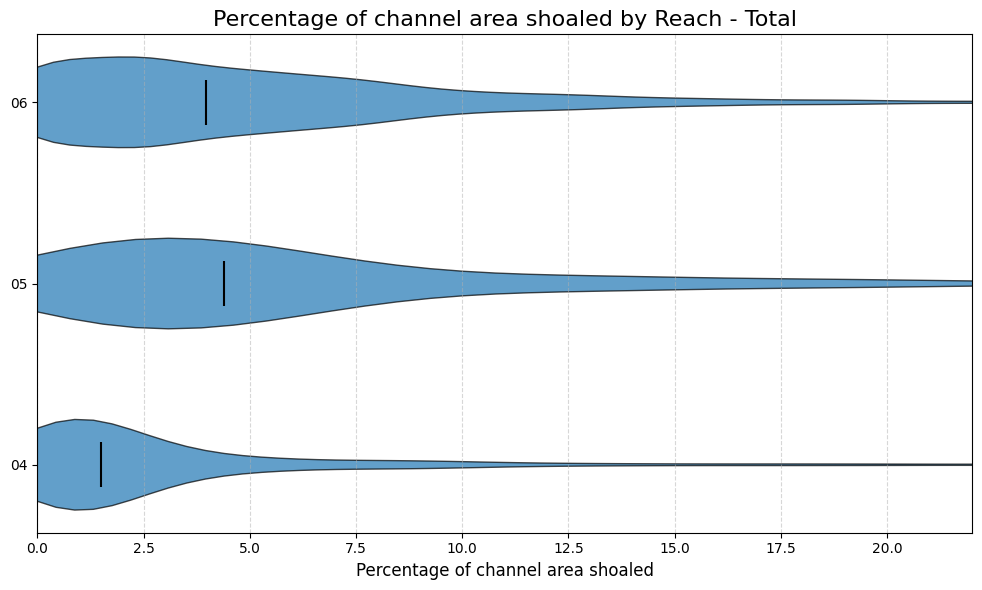

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
parts = plt.violinplot(box_data, 
                       vert=False, 
                       positions=range(1, len(box_data) + 1), 
                       showmeans=False, 
                       showextrema=False,
                       showmedians=True)

# Optional: make violins prettier (e.g., fill color)
for pc in parts['bodies']:
    pc.set_facecolor('#1f77b4')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

if 'cmedians' in parts:
    parts['cmedians'].set_color('black')

plt.yticks(ticks=range(1, len(reaches_csat) + 1), labels=clean_labels)
plt.xlabel("Percentage of channel area shoaled", fontdict={'fontsize': 12})
plt.title("Percentage of channel area shoaled by Reach - Total", fontdict={'fontsize': 16})
plt.tight_layout()
plt.xlim(0, 22)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()


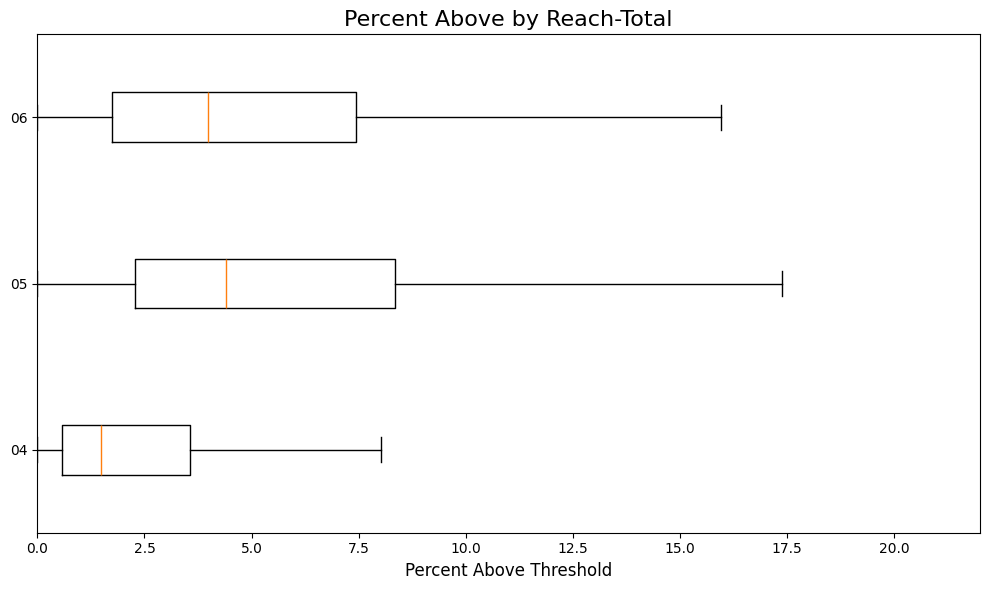

In [18]:
plt.figure(figsize=(10, 6))
plt.boxplot(box_data, vert=False, positions=range(1, len(box_data) + 1),showfliers=False)
plt.yticks(ticks=range(1, len(reaches_csat) + 1), labels=clean_labels)
plt.xlabel("Percent Above Threshold",fontdict={'fontsize': 12})
plt.title("Percent Above by Reach-Total",fontdict={'fontsize': 16})
plt.tight_layout()
plt.xlim(0, 22)
plt.show()

In [19]:
import pandas as pd
from scipy.stats import iqr

# Function to remove outliers using IQR method
def remove_outliers(data):
    q1 = np.nanpercentile(data, 25)
    q3 = np.nanpercentile(data, 75)
    iqr_val = iqr(data, nan_policy='omit')
    lower_bound = q1 - 1.5 * iqr_val
    upper_bound = q3 + 1.5 * iqr_val
    return [x for x in data if lower_bound <= x <= upper_bound]

# Calculate summary statistics for each reach in box_data, ignoring outliers
summary_stats_no_outliers_dredge = []
for i, data in enumerate(box_data_dredge):
    filtered_data = remove_outliers(data)
    stats = {
        'Reach': reaches_csat[i],
        'Mean': np.nanmean(filtered_data),
        'Median': np.nanmedian(filtered_data),
        'Std': np.nanstd(filtered_data),
        'Min': np.nanmin(filtered_data),
        'Max': np.nanmax(filtered_data),
        'Count': np.sum(~np.isnan(filtered_data))
    }
    summary_stats_no_outliers_dredge.append(stats)

summary_df_no_outliers_dredge = pd.DataFrame(summary_stats_no_outliers_dredge)
summary_df_no_outliers_dredge

,Reach,Mean,Median,Std,Min,Max,Count
0,SW_04_SWP_01_2025-06-23.zarr,3.768490,1.807528,4.857683,0.0,20.258399,957
1,SW_05_SWP_01_2025-06-23.zarr,5.524129,4.416097,4.365464,0.0,21.847585,1323
2,SW_06_SWP_01_2025-06-23.zarr,4.691009,3.622427,3.642847,0.0,15.434179,865


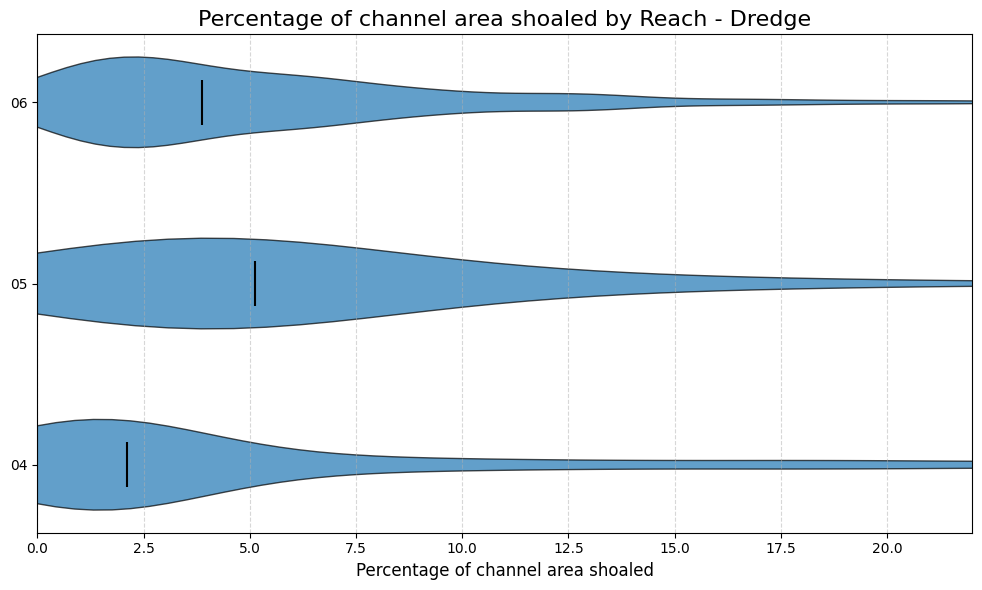

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
parts = plt.violinplot(box_data_dredge, 
                       vert=False, 
                       positions=range(1, len(box_data_dredge) + 1), 
                       showmeans=False, 
                       showextrema=False, 
                       showmedians=True)

# Optional: make violins prettier (e.g., fill color)
for pc in parts['bodies']:
    pc.set_facecolor('#1f77b4')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

if 'cmedians' in parts:
    parts['cmedians'].set_color('black')

plt.yticks(ticks=range(1, len(reaches_csat) + 1), labels=clean_labels)
plt.xlabel("Percentage of channel area shoaled", fontdict={'fontsize': 12})
plt.title("Percentage of channel area shoaled by Reach - Dredge", fontdict={'fontsize': 16})
plt.tight_layout()
plt.xlim(0, 22)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()


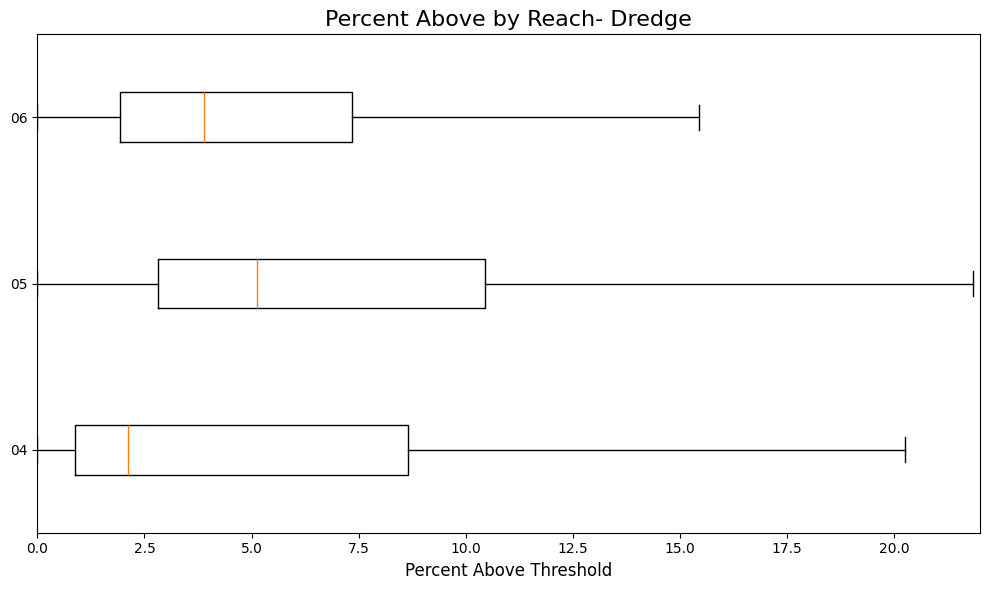

In [21]:
plt.figure(figsize=(10, 6))
plt.boxplot(box_data_dredge, vert=False, positions=range(1, len(box_data_dredge) + 1),showfliers=False)
plt.yticks(ticks=range(1, len(reaches_csat) + 1), labels=clean_labels)
plt.xlabel("Percent Above Threshold",fontdict={'fontsize': 12})
plt.title("Percent Above by Reach- Dredge",fontdict={'fontsize': 16})
plt.tight_layout()
plt.xlim(0,22)
plt.show()

In [22]:
summary_df_no_outliers_dredge

,Reach,Mean,Median,Std,Min,Max,Count
0,SW_04_SWP_01_2025-06-23.zarr,3.768490,1.807528,4.857683,0.0,20.258399,957
1,SW_05_SWP_01_2025-06-23.zarr,5.524129,4.416097,4.365464,0.0,21.847585,1323
2,SW_06_SWP_01_2025-06-23.zarr,4.691009,3.622427,3.642847,0.0,15.434179,865


In [23]:
summary_df_no_outliers

,Reach,Mean,Median,Std,Min,Max,Count
0,SW_04_SWP_01_2025-06-23.zarr,1.751490,1.236017,1.789123,0.0,8.020116,4277
1,SW_05_SWP_01_2025-06-23.zarr,4.782325,3.874578,3.968511,0.0,17.387869,4390
2,SW_06_SWP_01_2025-06-23.zarr,4.553546,3.703304,3.788059,0.0,15.955391,4667


In [24]:
box_data_no_dredge = []
for zarr_file in reaches_csat:
    zarr_array = xr.open_zarr(zarr_file)
    depth_data = zarr_array['depth'].values
    date_data = zarr_array['time'].values
    zarr_array.close()
    # Convert date_data to 'MM/DD/YYYY' string format for comparison
    date_data_mmddyyyy = np.array([pd.to_datetime(dt).strftime('%m/%d/%Y') for dt in date_data])

    # Find intersection between date_data and dqm_dates for the current reach
    reach_key = reach  # e.g., 'SW_06_SWP_01'
    dqm_dates_set = set(dqm_dates[zarr_file[:12]])
    dredge_percent_list = dredge_percent_collection(depth_data, date_data)

    # Get indices where date_data matches any DQM date
    non_intersect_indices = [i for i, d in enumerate(date_data_mmddyyyy) if d not in dqm_dates_set]

    # Get dredge_percent for those dates
    dredge_percent_on_dqm_dates = [dredge_percent_list[i-1][0] for i in non_intersect_indices]
    dredge_percent_on_dqm_dates
    box_data_no_dredge.append(dredge_percent_on_dqm_dates)

In [25]:
summary_stats_no_outliers_no_dredge = []
for i, data in enumerate(box_data_no_dredge):
    filtered_data = remove_outliers(data)
    stats = {
        'Reach': reaches_csat[i],
        'Mean': np.nanmean(filtered_data),
        'Median': np.nanmedian(filtered_data),
        'Std': np.nanstd(filtered_data),
        'Min': np.nanmin(filtered_data),
        'Max': np.nanmax(filtered_data),
        'Count': np.sum(~np.isnan(filtered_data))
    }
    summary_stats_no_outliers_no_dredge.append(stats)

In [26]:
summary_stats_no_outliers_no_dredge =pd.DataFrame(summary_stats_no_outliers_no_dredge)
summary_stats_no_outliers_no_dredge

,Reach,Mean,Median,Std,Min,Max,Count
0,SW_04_SWP_01_2025-06-23.zarr,1.569880,1.158822,1.554896,0.0,6.938488,3384
1,SW_05_SWP_01_2025-06-23.zarr,4.479680,3.550325,3.837908,0.0,16.047239,3063
2,SW_06_SWP_01_2025-06-23.zarr,4.522584,3.719031,3.820562,0.0,16.101870,3802


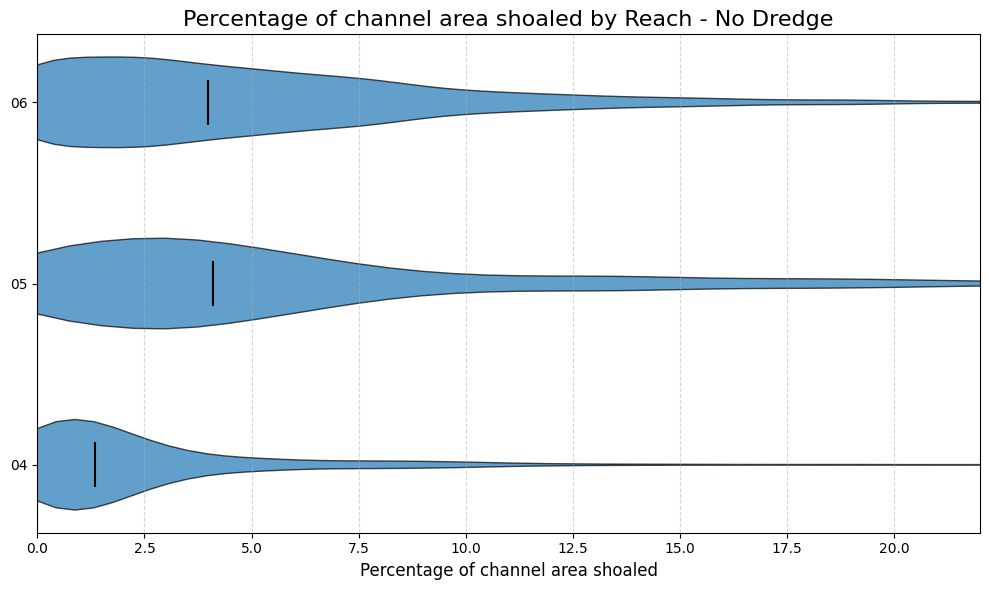

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
parts = plt.violinplot(box_data_no_dredge, 
                       vert=False, 
                       positions=range(1, len(box_data_no_dredge) + 1), 
                       showmeans=False, 
                       showextrema=False, 
                       showmedians=True)

# Optional: make violins prettier (e.g., fill color)
for pc in parts['bodies']:
    pc.set_facecolor('#1f77b4')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

if 'cmedians' in parts:
    parts['cmedians'].set_color('black')

plt.yticks(ticks=range(1, len(reaches_csat) + 1), labels=clean_labels)
plt.xlabel("Percentage of channel area shoaled", fontdict={'fontsize': 12})
plt.title("Percentage of channel area shoaled by Reach - No Dredge", fontdict={'fontsize': 16})
plt.tight_layout()
plt.xlim(0, 22)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()


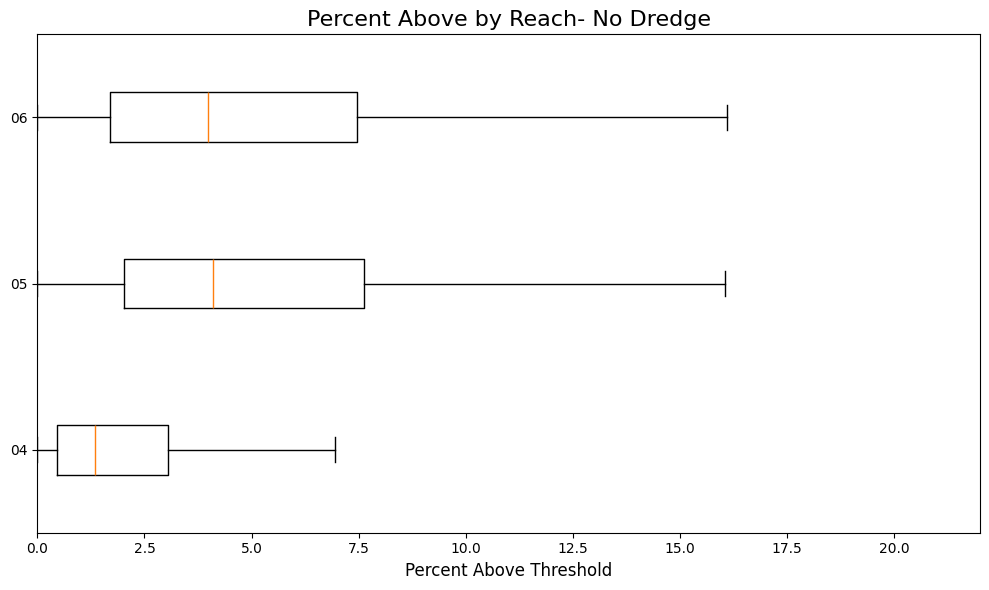

In [28]:
plt.figure(figsize=(10, 6))
plt.boxplot(box_data_no_dredge, vert=False, positions=range(1, len(box_data_no_dredge) + 1),showfliers=False)
plt.yticks(ticks=range(1, len(reaches_csat) + 1), labels=clean_labels)
plt.xlabel("Percent Above Threshold",fontdict={'fontsize': 12})
plt.title("Percent Above by Reach- No Dredge",fontdict={'fontsize': 16})
plt.tight_layout()
plt.xlim(0,22)
plt.show()